# Home Credit Default Risk

Import libraries and mount the google drive to access files into the google colab

In [ ]:
!pip install pyspc
!pip install matplotlib
!pip install spm1d

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import os
%matplotlib inline


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

  Created wheel for pyspc: filename=pyspc-0.4-py3-none-any.whl size=30874 sha256=c0b2af652bb3c875cd0069e2a4934f11b158d60227c703a6dff99a795e72c2de
  Stored in directory: /root/.cache/pip/wheels/1d/44/7a/6e67f7829fdbfd1e005ebaeb96ba96499d08af1d92c58d73d7
Successfully built pyspc
     |████████████████████████████████| 8.5 MB 11.3 MB/s 


Load Dataset

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':'18gtWITYpSplOXcskLThKtQe3dBSVcni4'}) 
downloaded.GetContentFile('application_train.csv')
application_train = pd.read_csv('application_train.csv')

In [ ]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
application_train.shape

(307511, 122)

## Exploratory Data Analysis

In [ ]:
print("application_train - (rows,columns):",application_train.shape)

application_train - (rows,columns): (307511, 122)


### Check Missing data

In [ ]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [ ]:
missing_val = missing_data(application_train)
#missing_val = missing_val[missing_val['Percent'] > 50]
missing_val.head(10)

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953


Removing features for which more than 50% of data is missing

In [ ]:
application_train = application_train.loc[:, ((application_train.isnull().sum()/application_train.isnull().count()*100).sort_values(ascending = False) < 50)]
application_train.shape

(307511, 81)

Below code tries to find out rows for which more than 50% of the cells are null (more than 29 cells). Although after running the code we did not find a single cell which had that many number of missing cells.

In [ ]:
percent_miss = (application_train.shape[1]*50)/100

for i in range(len(application_train.index)) :
  num_cell_miss = application_train.iloc[i].isnull().sum()
  #print("Nan in row ", i , " : " ,  num_cell_miss)

  if(num_cell_miss > percent_miss):
    print("Nan in row ", i , " : " ,  num_cell_miss)

Checking if the values are missing at random.

1. For Categorical variables - We will perform Chi Square test to check for any relations between these variables to determine if the missing values are MAR.

In [ ]:
cat_app_train = application_train.select_dtypes(include = 'object')
cat_app_train.shape

(307511, 13)

In [ ]:
from sklearn import preprocessing

label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame() 

for i in cat_app_train.columns :
  data_encoded[i]=label.fit_transform(cat_app_train[i])

data_encoded.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,EMERGENCYSTATE_MODE
0,0,1,0,1,6,7,4,3,1,8,6,5,0
1,0,0,0,0,1,4,1,1,1,3,1,39,0
2,1,1,1,1,6,7,4,3,1,8,1,11,2
3,0,0,0,1,6,7,4,0,1,8,6,5,2
4,0,1,0,1,6,7,4,3,1,3,4,37,2


In [ ]:
from scipy.stats import chi2_contingency

def chi_sqr(confusion_matrix):
  # Chi-square test of independence. 
  c, p, dof, expected = chi2_contingency(confusion_matrix) 
  # Print the p-value
  return p

In [ ]:
rows= []

for var1 in data_encoded:
  col = []
  for var2 in data_encoded :
    confusion_matrix = pd.crosstab(data_encoded[var1], data_encoded[var2])
    chi_sqr_val = chi_sqr(confusion_matrix) 
    col.append(chi_sqr_val)
  rows.append(col)
  
ch_results = np.array(rows)
chi_df = pd.DataFrame(ch_results, columns = data_encoded.columns, index =data_encoded.columns)

In [ ]:
for col in chi_df:
  for row in chi_df.index:
    if(chi_df[col][row] > 0.05):
      print(col, row, "p-value = ", chi_df[col][row])

FLAG_OWN_CAR FLAG_OWN_REALTY p-value =  0.11927783850888878
FLAG_OWN_REALTY FLAG_OWN_CAR p-value =  0.11927783850888878


Thus FLAG_OWN_CAR and FLAG_OWN_REALTY are the only features which are not related to each other. This infers that we can impute all the other categorical variables which have missing values in them using regression or a propensity score model.

Now we will check if FLAG_OWN_CAR and FLAG_OWN_REALTY have any missing values.

In [ ]:
print(application_train['FLAG_OWN_CAR'].isnull().sum())
print(application_train['FLAG_OWN_REALTY'].isnull().sum())

0
0


We can ignore the above two features and leave them as they are.

Now moving on to the numerical data.

2. For Numerical Data - We will check the relation using Pearson's Correlation Coefficient. 

*Also*, there are no missing values in the outcome variable.

In [ ]:
print("Total missing values in TARGET " + str(application_train['TARGET'].isnull().sum()))

Total missing values in TARGET 0


In [ ]:
num_app_train = application_train.select_dtypes(exclude = 'object')

In [ ]:
pearsoncorr = num_app_train.corr(method='pearson')
high_corr_var=np.where(pearsoncorr>0.8)
high_corr_var=[(pearsoncorr.columns[x],pearsoncorr.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]

Following are the pairs having a high correlation

In [ ]:
high_corr_var

[('CNT_CHILDREN', 'CNT_FAM_MEMBERS'),
 ('AMT_CREDIT', 'AMT_GOODS_PRICE'),
 ('REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY'),
 ('REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION'),
 ('REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY'),
 ('YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MODE'),
 ('YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MEDI'),
 ('FLOORSMAX_AVG', 'FLOORSMAX_MODE'),
 ('FLOORSMAX_AVG', 'FLOORSMAX_MEDI'),
 ('YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_MEDI'),
 ('FLOORSMAX_MODE', 'FLOORSMAX_MEDI'),
 ('OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE'),
 ('DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE')]

In [ ]:
miss_cols = []

for col in application_train:
  
  if(application_train[col].isnull().sum() > 0 and application_train[col].dtype != object):
    miss_cols.append(col)

Following are the continuous variables having missing values

In [ ]:
miss_cols

['AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'YEARS_BEGINEXPLUATATION_AVG',
 'FLOORSMAX_AVG',
 'YEARS_BEGINEXPLUATATION_MODE',
 'FLOORSMAX_MODE',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'FLOORSMAX_MEDI',
 'TOTALAREA_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [ ]:
corr_miss = []
remove_corr_miss = []

for pair in high_corr_var:
  if(pair[0] in miss_cols and pair[1] not in miss_cols):
    print("Missing variable ", pair[0], " is highly correlated with ", pair[1])
    corr_miss.append(pair[0])
  elif(pair[1] in miss_cols and pair[0] not in miss_cols):
    print("Missing variable ", pair[1], " is highly correlated with ", pair[0])
    corr_miss.append(pair[1])
  elif(pair[0] in miss_cols and pair[1] in miss_cols):
    print("Both Missing variables ", pair[0], " and ", pair[1], " are highly correlated with each other")
    remove_corr_miss.append(pair[0])
    remove_corr_miss.append(pair[1])

Missing variable  CNT_FAM_MEMBERS  is highly correlated with  CNT_CHILDREN
Missing variable  AMT_GOODS_PRICE  is highly correlated with  AMT_CREDIT
Both Missing variables  YEARS_BEGINEXPLUATATION_AVG  and  YEARS_BEGINEXPLUATATION_MODE  are highly correlated with each other
Both Missing variables  YEARS_BEGINEXPLUATATION_AVG  and  YEARS_BEGINEXPLUATATION_MEDI  are highly correlated with each other
Both Missing variables  FLOORSMAX_AVG  and  FLOORSMAX_MODE  are highly correlated with each other
Both Missing variables  FLOORSMAX_AVG  and  FLOORSMAX_MEDI  are highly correlated with each other
Both Missing variables  YEARS_BEGINEXPLUATATION_MODE  and  YEARS_BEGINEXPLUATATION_MEDI  are highly correlated with each other
Both Missing variables  FLOORSMAX_MODE  and  FLOORSMAX_MEDI  are highly correlated with each other
Both Missing variables  OBS_30_CNT_SOCIAL_CIRCLE  and  OBS_60_CNT_SOCIAL_CIRCLE  are highly correlated with each other
Both Missing variables  DEF_30_CNT_SOCIAL_CIRCLE  and  DEF_

In [ ]:
remove_corr_miss

['YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'FLOORSMAX_AVG',
 'FLOORSMAX_MODE',
 'FLOORSMAX_AVG',
 'FLOORSMAX_MEDI',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'FLOORSMAX_MODE',
 'FLOORSMAX_MEDI',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE']

These variables are correlated with each other but both of them have missing values. It will be difficult to determine whether they are not NMAR. Hence, we would be removing these variables.

In [ ]:
application_train.drop(remove_corr_miss, axis=1, inplace = True)
application_train.shape

(307511, 71)

Below variables have a relationship with other variables and hence they can be considered MAR. These variables can be imputed using regression or a propensity score model.

In [ ]:
corr_miss

['CNT_FAM_MEMBERS', 'AMT_GOODS_PRICE']

Also we will check for the other variables which do not have any relationship.

In [ ]:
not_rel_miss = []

for col in miss_cols:
  if col not in (corr_miss + remove_corr_miss):
    print(col)
    not_rel_miss.append(col)

AMT_ANNUITY
EXT_SOURCE_2
EXT_SOURCE_3
TOTALAREA_MODE
DAYS_LAST_PHONE_CHANGE
AMT_REQ_CREDIT_BUREAU_HOUR
AMT_REQ_CREDIT_BUREAU_DAY
AMT_REQ_CREDIT_BUREAU_WEEK
AMT_REQ_CREDIT_BUREAU_MON
AMT_REQ_CREDIT_BUREAU_QRT
AMT_REQ_CREDIT_BUREAU_YEAR


We will visualize these variables to check whether they can be determined to be NMAR or MCAR.

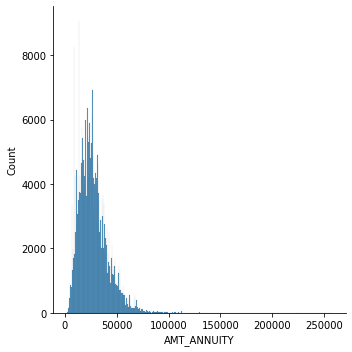

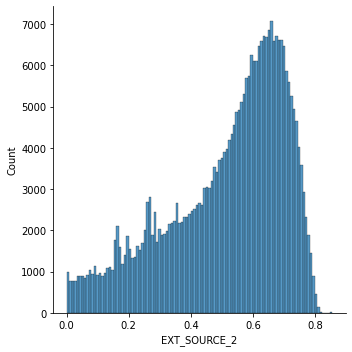

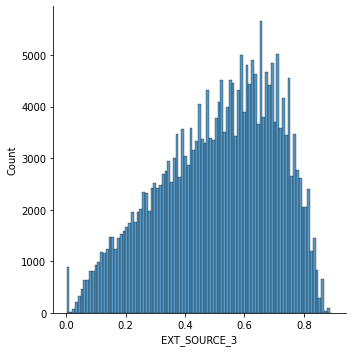

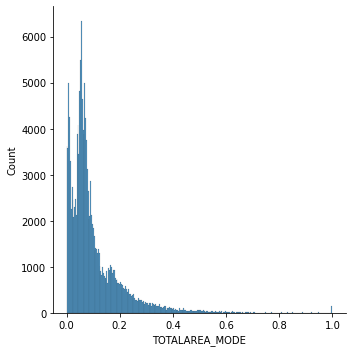

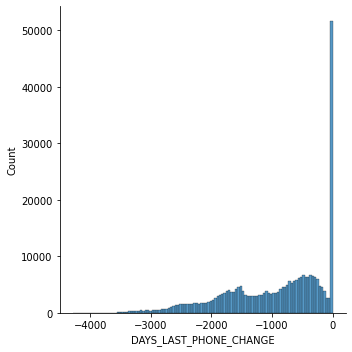

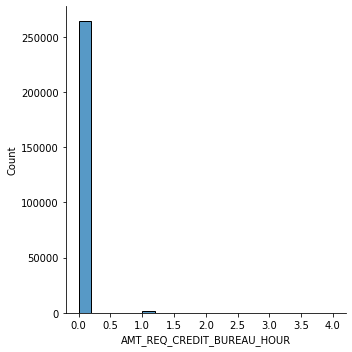

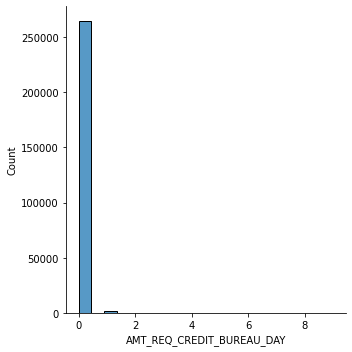

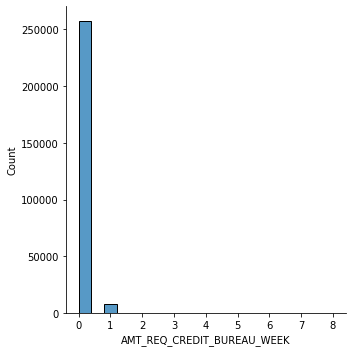

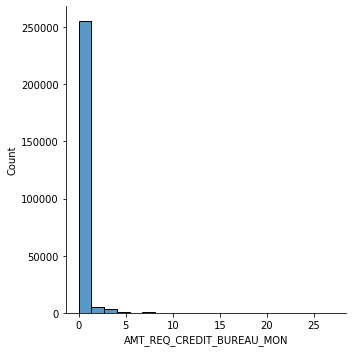

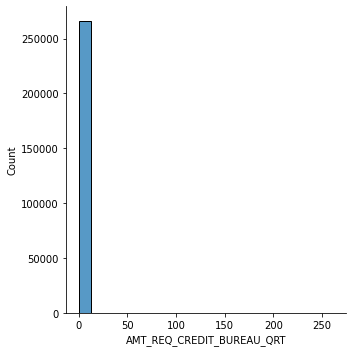

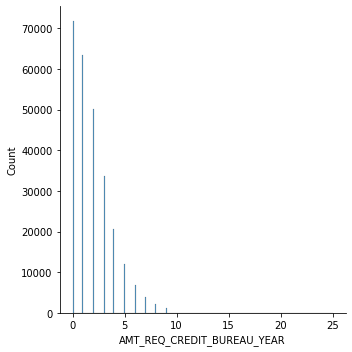

In [ ]:
for col in not_rel_miss:
  sns.displot(application_train, x=col)

DAYS_LAST_PHONE_CHANGE,
AMT_REQ_CREDIT_BUREAU_HOUR,
AMT_REQ_CREDIT_BUREAU_DAY,
AMT_REQ_CREDIT_BUREAU_WEEK,
AMT_REQ_CREDIT_BUREAU_MON,
AMT_REQ_CREDIT_BUREAU_QRT,
AMT_REQ_CREDIT_BUREAU_YEAR

These variables seem highly imbalanced and it wouldn't be sensible to impute them or include them in our clean data. Hence, we would remove these variables. Other variables can be considered as MCAR after looking at their distributions and can be imputed using Median or Mode since there distributions aren't normal.

In [ ]:
application_train.drop(['DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'], axis=1, inplace = True)

In [ ]:
application_train.shape

(307511, 64)

### Imputing Missing data

The variables analyzed above for imputation will be imputed based on whether they are MCAR or MAR.

1. MCAR Imputation - We will impute them with the median since their distribution is skewed.

In [ ]:
miss_MCAR = ['AMT_ANNUITY',
'EXT_SOURCE_2',
'EXT_SOURCE_3',
'TOTALAREA_MODE']

In [ ]:
for col in miss_MCAR:
  application_train[col].fillna(application_train[col].median(),inplace=True)

In [ ]:
application_train["AMT_ANNUITY"].isnull().sum()

0

2. MAR Imputation - 

> Continuous variables - We will impute them using Linear Regression

In [ ]:
num_app_train = application_train.select_dtypes(exclude = 'object')

for col in num_app_train:
  if(application_train[col].isnull().sum() > 0):
    print(col)

AMT_GOODS_PRICE
CNT_FAM_MEMBERS


In [ ]:
from sklearn.linear_model import LinearRegression

X = application_train.select_dtypes(exclude = 'object')
X = X.loc[:, ~X.columns.isin(['AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS'])]

Y1 = application_train['AMT_GOODS_PRICE']
Y2 = application_train['CNT_FAM_MEMBERS']

Getting indices of the missing values and then creating a train and test set based on these indices.

In [ ]:
Y1_miss_idx = application_train[application_train['AMT_GOODS_PRICE'].isnull()].index.tolist()
Y2_miss_idx = application_train[application_train['CNT_FAM_MEMBERS'].isnull()].index.tolist()

In [ ]:
X1_train = X.loc[Y1.drop(Y1_miss_idx, axis=0).index]
X2_train = X.loc[Y2.drop(Y2_miss_idx, axis=0).index]
Y1_train = Y1.loc[Y1.drop(Y1_miss_idx, axis=0).index]
Y2_train = Y2.loc[Y2.drop(Y2_miss_idx, axis=0).index]

In [ ]:
X1_test = X.iloc[Y1_miss_idx]
X2_test = X.iloc[Y2_miss_idx]

In [ ]:
linear_regressor1 = LinearRegression()
linear_regressor1.fit(X1_train, Y1_train)
Y1_pred = linear_regressor1.predict(X1_test)
application_train.loc[Y1_miss_idx, 'AMT_GOODS_PRICE'] = Y1_pred

linear_regressor2 = LinearRegression()
linear_regressor2.fit(X2_train, Y2_train)
Y2_pred = linear_regressor2.predict(X2_test)
application_train.loc[Y2_miss_idx, 'CNT_FAM_MEMBERS'] = Y2_pred

In [ ]:
print(application_train['AMT_GOODS_PRICE'].isnull().sum())
print(application_train['CNT_FAM_MEMBERS'].isnull().sum())

0
0




> Categorical Variables - We will impute them using Logistic Regression

In [ ]:
miss_cat_app_train = [col for col in cat_app_train if application_train[col].isnull().sum() > 0]
miss_cat_app_train

['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'EMERGENCYSTATE_MODE']

In [ ]:
#X = application_train.select_dtypes(include = 'object')
X = X.loc[:, ~X.columns.isin(['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'EMERGENCYSTATE_MODE'])]

Y1 = application_train['NAME_TYPE_SUITE']
Y2 = application_train['OCCUPATION_TYPE']
Y3 = application_train['EMERGENCYSTATE_MODE']

Following the same procedure as we followed for Linear regression.

In [ ]:
Y1_miss_idx = application_train[application_train['NAME_TYPE_SUITE'].isnull()].index.tolist()
Y2_miss_idx = application_train[application_train['OCCUPATION_TYPE'].isnull()].index.tolist()
Y3_miss_idx = application_train[application_train['EMERGENCYSTATE_MODE'].isnull()].index.tolist()

In [ ]:
X_train = X.loc[Y1.drop(Y1_miss_idx + Y2_miss_idx + Y3_miss_idx, axis=0).index]
Y1_train = Y1.loc[Y1.drop(Y1_miss_idx + Y2_miss_idx + Y3_miss_idx, axis=0).index]
Y2_train = Y2.loc[Y2.drop(Y1_miss_idx + Y2_miss_idx + Y3_miss_idx, axis=0).index]
Y3_train = Y3.loc[Y2.drop(Y1_miss_idx + Y2_miss_idx + Y3_miss_idx, axis=0).index]

In [ ]:
X1_test = X.iloc[Y1_miss_idx]
X2_test = X.iloc[Y2_miss_idx]
X3_test = X.iloc[Y3_miss_idx]

In [ ]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

for col in X_train:
  if(X_train[col].dtype == object):
    X_train[col]= label_encoder.fit_transform(X_train[col]) 
    X1_test[col]= label_encoder.fit_transform(X1_test[col]) 
    X2_test[col]= label_encoder.fit_transform(X2_test[col]) 
    X3_test[col]= label_encoder.fit_transform(X3_test[col]) 

Y1_train= label_encoder.fit_transform(Y1_train) 
Y2_train= label_encoder.fit_transform(Y2_train) 
Y3_train= label_encoder.fit_transform(Y3_train) 

In [ ]:
from sklearn.linear_model import LogisticRegression

model1 = LogisticRegression(solver='lbfgs', max_iter=100)
model1.fit(X_train, Y1_train)
Y1_pred = model1.predict(X1_test)

In [ ]:
Y1_test = Y1.iloc[Y1_miss_idx]
# print("Accuracy: ", model1.score(Y1_test,Y1_pred)*100)

In [ ]:
X_train.shape

(110504, 49)

Thus it can be observed that the logistic regression model fails to converge. This is because "Limited-memory Broyden–Fletcher–Goldfarb–Shanno Algorithm" works better on smaller datasets. Hence, we would not be using these 3 variables in our final dataset.

In [ ]:
application_train[miss_cat_app_train].isnull().sum()

NAME_TYPE_SUITE          1292
OCCUPATION_TYPE         96391
EMERGENCYSTATE_MODE    145755
dtype: int64

We will be handling these 3 variables in different ways.

1. NAME_TYPE_SUITE - We will remove the rows containing missing values since the number of rows is not large compared to the size of the entire dataset.

In [ ]:
application_train['NAME_TYPE_SUITE'].dropna(axis = 0)

0         Unaccompanied
1                Family
2         Unaccompanied
3         Unaccompanied
4         Unaccompanied
              ...      
307506    Unaccompanied
307507    Unaccompanied
307508    Unaccompanied
307509    Unaccompanied
307510    Unaccompanied
Name: NAME_TYPE_SUITE, Length: 306219, dtype: object

Since the number of missing rows for OCCUPATION_TYPE is large we won't be removing its rows. We will replace the missing occupation type with a value 'Other'

In [ ]:
application_train['OCCUPATION_TYPE'].value_counts()

Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64

Due to the extremely large number of missing values in EMERGENCYSTATE_MODE we will drop this column.

In [ ]:
application_train.drop(['EMERGENCYSTATE_MODE'], axis=1, inplace = True)

In [ ]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0,0,0,0


# Handling Noisy Data

We will apply the Binning method to smooth the data.

In [ ]:
noise_app = application_train.select_dtypes(exclude = 'object')
noise_app.shape

(307511, 51)

In [ ]:
for col in noise_app:
  print(application_train[col].describe())
  print(application_train[col].value_counts(bins=4, sort=False))

count    307511.000000
mean     278180.518577
std      102790.175348
min      100002.000000
25%      189145.500000
50%      278202.000000
75%      367142.500000
max      456255.000000
Name: SK_ID_CURR, dtype: float64
(99645.746, 189065.25]    76804
(189065.25, 278128.5]     76886
(278128.5, 367191.75]     76987
(367191.75, 456255.0]     76834
Name: SK_ID_CURR, dtype: int64
count    307511.000000
mean          0.080729
std           0.272419
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: TARGET, dtype: float64
(-0.002, 0.25]    282686
(0.25, 0.5]            0
(0.5, 0.75]            0
(0.75, 1.0]        24825
Name: TARGET, dtype: int64
count    307511.000000
mean          0.417052
std           0.722121
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          19.000000
Name: CNT_CHILDREN, dtype: float64
(-0.02, 4.75]    307385
(4.75, 9.5]         116
(9.5, 14.25]     

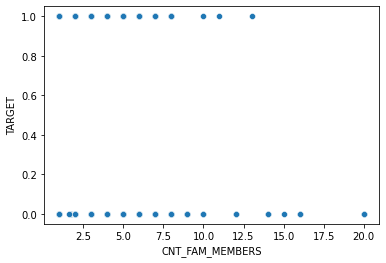

In [ ]:
sns.scatterplot(data=application_train, x="CNT_FAM_MEMBERS", y="TARGET")

### Label encoder

In [ ]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

In [ ]:
encoded = application_train.select_dtypes(include=['object']).apply(LabelEncoder().fit_transform)
encoded

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,0,1,0,1,6,7,4,3,1,8,6,5
1,0,0,0,0,1,4,1,1,1,3,1,39
2,1,1,1,1,6,7,4,3,1,8,1,11
3,0,0,0,1,6,7,4,0,1,8,6,5
4,0,1,0,1,6,7,4,3,1,3,4,37
...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,1,0,0,6,7,4,2,5,14,4,43
307507,0,0,0,1,6,3,4,5,1,18,1,57
307508,0,0,0,1,6,7,1,2,1,10,4,39
307509,0,0,0,1,6,1,4,1,1,8,6,3


In [ ]:
application_train_encode = pd.concat([application_train.select_dtypes(exclude=['object']),encoded],axis=1)

In [ ]:
application_train_encode.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,0,1,6,7,4,3,1,8,6,5
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,0,0,1,4,1,1,1,3,1,39
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,1,1,6,7,4,3,1,8,1,11
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,0,1,6,7,4,0,1,8,6,5
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,0,1,6,7,4,3,1,3,4,37


### Multivariate outlier detection



In [ ]:
# app_outlier_train_subset = application_train[['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'TOTALAREA_MODE']]

In [ ]:
app_outlier_train = application_train_encode

The code below use the Hotelling T-Square as a reference to determine whether a multivariate point is an outlier.

In [ ]:
# x=app_outlier_train.values.tolist()

# from pyspc import *

# a = spc(x) + Tsquare_single()

# print(a)

We calculated the Hotellings T-Squared from n rows with k columns to get our critical values. The Mahalanobis distance for each row is then calculated from the overall multivariate mean X. (xbar). Use this distance in conjunction with the covariance matrix to compute individual Hotelling T Squared statistics, which you can then compare to the crucial Hotellings T Squared values.

In [ ]:
from scipy.stats import f

x=application_train_encode.values.tolist()
#print(x))
n=len(x)
k=len(x[0])
vals = f.ppf([0.99], n, k)*(n*k)/((n-k)+1)
print(vals)
rv = f(len(x), len(x[0]))

[99.6091944]


Text(0.5, 1.0, 'Multivariate Charts  ')

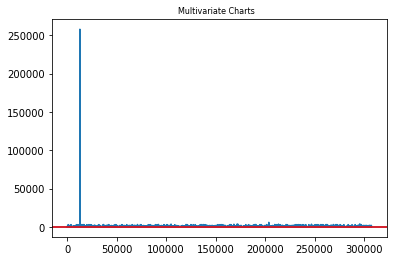

In [ ]:
from  scipy.spatial import distance
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f
#print(app_outlier_train.cov())
inv_cov = pd.DataFrame(np.linalg.pinv(app_outlier_train.cov().values), app_outlier_train.cov().columns, app_outlier_train.cov().index).values.tolist()
x=app_outlier_train.values.tolist()
xbar=app_outlier_train.mean().tolist()

n=len(x)
k=len(x[0])
## Convert f value to hotellings critical value at 1% level
##https://en.wikipedia.org/wiki/Hotelling%27s_T-squared_distribution

Hotvalue = f.ppf([0.99], n, k)*(n*k)/((n-k)+1)
# print(Hotvalue)

## calculating hoteling test statistic for each row in boston dataset 

for i in range(0,len(x)):
  
  app_outlier_train.loc[app_outlier_train.index==i,'hotelling']=(n*k)*distance.mahalanobis(x[i], xbar, inv_cov)**2/(k*(n-k))
  app_outlier_train.loc[app_outlier_train.index==i,'critical value']=Hotvalue

x=np.array(app_outlier_train.index.tolist())
y1=np.array(app_outlier_train['hotelling'])
f = plt.figure()

ax = f.add_subplot(111)

plt.plot(x, y1)
plt.axhline(y=app_outlier_train['hotelling'].mean())
plt.axhline(y=Hotvalue,color='r')
#plt.axhline(y=app_outlier_train['hotelling'].mean()+3*app_outlier_train['hotelling'].std(),color='r')
#plt.axhline(y=app_outlier_train['hotelling'].mean()-3*app_outlier_train['hotelling'].std(),color='r')

plt.title('Multivariate Charts  ', fontsize=8)


In [ ]:
# from  scipy.spatial import distance
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import f
# #print(app_outlier_train.cov())
# inv_cov = pd.DataFrame(np.linalg.pinv(app_outlier_train.cov().values), app_outlier_train.cov().columns, app_outlier_train.cov().index).values.tolist()
# x=app_outlier_train.values.tolist()
# xbar=app_outlier_train.mean().tolist()

# n=len(x)
# k=len(x[0])
# ## Convert f value to hotellings critical value at 1% level
# ##https://en.wikipedia.org/wiki/Hotelling%27s_T-squared_distribution

# Hotvalue = f.ppf([0.99], n, k)*(n*k)/((n-k)+1)
# # print(Hotvalue)

# ## calculating hoteling test statistic for each row in boston dataset 

# for i in range(0,len(x)):
  
#   app_outlier_train.loc[app_outlier_train.index==i,'hotelling']=(n*k)*distance.mahalanobis(x[i], xbar, inv_cov)**2/(k*(n-k))
#   app_outlier_train.loc[app_outlier_train.index==i,'critical value']=Hotvalue

# x=np.array(app_outlier_train.index.tolist())
# y1=np.array(app_outlier_train['hotelling'])
# f = plt.figure()

# ax = f.add_subplot(111)

# plt.plot(x, y1)
# plt.axhline(y=app_outlier_train['hotelling'].mean())
# plt.axhline(y=Hotvalue,color='r')
# #plt.axhline(y=app_outlier_train['hotelling'].mean()+3*app_outlier_train['hotelling'].std(),color='r')
# #plt.axhline(y=app_outlier_train['hotelling'].mean()-3*app_outlier_train['hotelling'].std(),color='r')

# plt.title('Multivariate Charts  ', fontsize=8)


In [ ]:
print(app_outlier_train.loc[app_outlier_train['hotelling']>app_outlier_train['critical value'],['SK_ID_CURR', 'hotelling', 'critical value']].sort_values(by='hotelling',ascending=False))

        SK_ID_CURR      hotelling  critical value
12840       114967  257781.000000       99.609194
203693      336147    5961.020860       99.609194
295656      442538    3915.317009       99.609194
171708      299000    3757.651454       99.609194
104938      221773    3691.256130       99.609194
...            ...            ...             ...
2362        102764      99.618621       99.609194
56083       164991      99.618469       99.609194
81478       194476      99.616411       99.609194
282396      427061      99.616189       99.609194
20790       124229      99.611162       99.609194

[22029 rows x 3 columns]


In [ ]:
application_train[application_train['SK_ID_CURR']==114967]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
12840,114967,1,Cash loans,F,N,Y,1,117000000.0,562491.0,26194.5,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def analyse_outliers(df, column):
    
    # Print Summary Statistics
    print('Summary Statistics:\n')
    print(df[column].describe())

    # find mean and std
    outlier_df = df[column]
    std = outlier_df.std()
    print('\nStandard Deviation: ', std)
    mean =  outlier_df.mean()
    print('Mean: ', mean)

    # how many std is the max
    max_outlier = int((outlier_df.max() - mean) / std)

    # separate outliers over 2 std from mean
    outliers_l = outlier_df[(outlier_df < mean - 2 * std)]
    outliers_h = outlier_df[(outlier_df > mean + 2 * std)]
    print('\nThere are {} low end outliers in the {} dataset'.format(len(outliers_l), column ))    
    print('There are {} high end outliers in the {} dataset'.format(len(outliers_h), column ))
    print('The max value is {} standard deviations from the mean'.format(max_outlier))
    
    return mean, std


In [ ]:
for col in ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']:
    income_mean, income_std = analyse_outliers(application_train,col)

Summary Statistics:

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

Standard Deviation:  237123.14627883647
Mean:  168797.9192969845

There are 0 low end outliers in the AMT_INCOME_TOTAL dataset
There are 1438 high end outliers in the AMT_INCOME_TOTAL dataset
The max value is 492 standard deviations from the mean
Summary Statistics:

count    3.075110e+05
mean     5.990260e+05
std      4.024908e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.135310e+05
75%      8.086500e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64

Standard Deviation:  402490.776995946
Mean:  599025.9997057016

There are 0 low end outliers in the AMT_CREDIT dataset
There are 12999 high end outliers in the AMT_CREDIT dataset
The max value is 8 standard deviations from the mean
Summary Statistics:

count    307511.000000
mean     

### Measuring Multicollinearity

In [ ]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

feature_names = ['TARGET','CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'TOTALAREA_MODE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']
app_test = application_train[feature_names]
app_test.dropna(how='any')
X=app_test[feature_names[1:]]
# Use the next line if you want to drop DIS and RAD
#X= X[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE' , 'TAX', 'PTRATIO','B', 'LSTAT']]

y=app_test['TARGET']
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size = 0.2, random_state=5)

X = sm.add_constant(X_train_1)
model = sm.OLS(y_train_1,X)
results = model.fit()
y_pred=results.predict(X)

rms = np.sqrt(mean_squared_error(y_train_1, y_pred))
#

# X_test = add_constant(X_test_1)
# print(X_test)
# y_test_pred=results.predict(X_test)
# rms_test = np.sqrt(mean_squared_error(y_test_1, y_test_pred))

print("training root mean Square error is: ",rms)
# print("test root mean Square error is: ",rms_test)
print(results.summary())

training root mean Square error is:  0.26548298059546255
                            OLS Regression Results                            
Dep. Variable:                 TARGET   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     290.2
Date:                Fri, 08 Apr 2022   Prob (F-statistic):               0.00
Time:                        16:43:14   Log-Likelihood:                -22813.
No. Observations:              246008   AIC:                         4.573e+04
Df Residuals:                  245958   BIC:                         4.625e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from statsmodels.api import add_constant
import pandas as pd



X = add_constant(X_train_1)

vif = [variance_inflation_factor(X.to_numpy(), i) for i in range(X.to_numpy().shape[1])]
print(vif[1:])

print("VIF > 5:",X.columns[np.where(np.asarray(vif[1:])>5)])
print("VIF > 10:",X.columns[np.where(np.asarray(vif[1:])>10)])

[4.675963321677839, 1.0450922581435924, 42.34151257345848, 2.7447918505094946, 43.40400099425316, 1.4533216512178817, 2.1012919978274427, 2125.910025021547, 1.1545736633075667, 1.136312583031491, 1.0005854563611096, 2143.2566859713274, 1.2322900801550458, 1.0174197266628173, 1.1462276040836652, 1.0233176921460554, 4.546651832918653, 10.856462229057062, 10.724437632274727, 1.1225185459275773, 2.423273885069985, 9.039560625027107, 7.340014288406629, 2.4289951474887457, 7.487446326736667, 6.020430827434001, 1.156040688013444, 1.055692738463666, 1.0654155718408989, 1.0007615562285366, 2.71560553692099, 1.0010296678022115, 1.1609508889522262, 2.4276870540774342, 1.0035420039466363, 1.8551552564637357, 1.045736258814761, 1.0004862893845499, 1.0684035257949156, 1.000165562387846, 1.018020411432436, 1.0150446775267685, 1.0041572686576055, 1.020290233862012, 1.0012575661809722, 1.020459680093344, 1.0031733788072623, 1.0214925934022423, 1.0032808429583817]
VIF > 5: Index(['AMT_INCOME_TOTAL', 'AM

In [ ]:
application_train['DAYS_BIRTH_YEAR'] = (np.absolute(application_train['DAYS_BIRTH'])/365).astype('int')


In [ ]:
application_train.drop('DAYS_BIRTH', axis=1, inplace=True)

In [ ]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,DAYS_BIRTH_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,0,0,0,25
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0,0,0,0,0,45
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0,0,0,52
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0,0,0,52
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0,0,0,54


In [ ]:
def year_categorical(year):
  if year < 20:
    return 0
  elif year >=20 and year <= 40:
    return 1
  elif year > 40 and year <= 60:
    return 2
  elif year > 60 and year <= 80:
    return 3
  elif year > 80 and year <= 100:
    return 4
  else:
    return 5

In [ ]:
application_train['YEAR_CAT'] = application_train['DAYS_BIRTH_YEAR'].apply(lambda x: year_categorical(x))

In [ ]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,DAYS_BIRTH_YEAR,YEAR_CAT
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,0,0,25,1
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0,0,0,0,45,2
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0,0,52,2
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0,0,52,2
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0,0,54,2


In [ ]:
# import statsmodels.api as sm
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.metrics import mean_squared_error

# feature_names = ['TARGET','CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'TOTALAREA_MODE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21','DAYS_BIRTH_YEAR', 'YEAR_CAT']
# app_test = application_train[feature_names]
# app_test.dropna(how='any')
# X=app_test[feature_names[1:]]
# # Use the next line if you want to drop DIS and RAD
# #X= X[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE' , 'TAX', 'PTRATIO','B', 'LSTAT']]

# y=app_test['TARGET']
# X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size = 0.2, random_state=5)

# X = sm.add_constant(X_train_1)
# model = sm.OLS(y_train_1,X)
# results = model.fit()
# y_pred=results.predict(X)

# rms = np.sqrt(mean_squared_error(y_train_1, y_pred))
# #

# # X_test = add_constant(X_test_1)
# # print(X_test)
# # y_test_pred=results.predict(X_test)
# # rms_test = np.sqrt(mean_squared_error(y_test_1, y_test_pred))

# print("training root mean Square error is: ",rms)
# # print("test root mean Square error is: ",rms_test)
# print(results.summary())

In [ ]:
# X = add_constant(X_train_1)

# vif = [variance_inflation_factor(X.to_numpy(), i) for i in range(X.to_numpy().shape[1])]
# print(vif[1:])

# print("VIF > 5:",X.columns[np.where(np.asarray(vif[1:])>5)])
# print("VIF > 10:",X.columns[np.where(np.asarray(vif[1:])>10)])

### Factor Analysis of Mixed Data

In [ ]:
!pip install prince

In [ ]:
application_train.shape

(307511, 64)

In [ ]:
import prince
app_famd_train = application_train[['AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'FLAG_MOBIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY','FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL','FLAG_OWN_CAR', 'FLAG_OWN_REALTY']]
app_famd_train.head()


,AMT_INCOME_TOTAL,AMT_ANNUITY,FLAG_MOBIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,FLAG_OWN_CAR,FLAG_OWN_REALTY
0,202500.0,24700.5,1,1.0,2,2,WEDNESDAY,10,0,0,...,0,0,0,1,0,1,1,0,N,Y
1,270000.0,35698.5,1,2.0,1,1,MONDAY,11,0,0,...,0,0,0,1,0,1,1,0,N,N
2,67500.0,6750.0,1,1.0,2,2,MONDAY,9,0,0,...,0,0,0,1,1,1,1,0,Y,Y
3,135000.0,29686.5,1,2.0,2,2,WEDNESDAY,17,0,0,...,0,0,0,1,0,1,0,0,N,Y
4,121500.0,21865.5,1,1.0,2,2,THURSDAY,11,0,0,...,0,0,0,1,0,1,0,0,N,Y


In [ ]:
famd = prince.FAMD(n_components=2, n_iter=3,copy=True,check_input=True,engine='auto', random_state=42 )
famd = famd.fit(app_famd_train) 
#famd.row_coordinates(X)
df_famd = famd.transform(app_famd_train)
df_famd.columns = ["FAMD_OUTPUT1", "FAMD_OUTPUT2"]

No handles with labels found to put in legend.


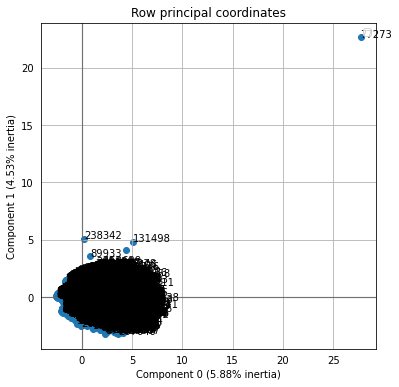

In [ ]:
ax = famd.plot_row_coordinates(app_famd_train,ax=None,figsize=(6, 6),x_component=0, y_component=1,labels=X.index,
                               ellipse_outline=False,
                               ellipse_fill=True,
                               show_points=True)


In [ ]:
df_famd.head(10)

,FAMD_OUTPUT1,FAMD_OUTPUT2
0,-0.782251,0.014533
1,0.258830,-0.967696
2,0.002395,1.075848
3,-0.550874,0.075095
4,0.353592,0.241332
5,-0.371879,-0.180074
6,1.219423,1.567906
7,1.098671,0.664624
8,-1.064689,0.174969
9,-0.979663,0.141321


In [ ]:
application_train = pd.concat([application_train, df_famd],axis=1)

In [ ]:
application_train.drop(['AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'FLAG_MOBIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT','FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL','FLAG_OWN_CAR', 'FLAG_OWN_REALTY'], axis=1, inplace=True)

In [ ]:
application_train.shape

(307511, 34)

In [ ]:
# import sys
# def sizeof_fmt(num, suffix='B'):
#     ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
#     for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
#         if abs(num) < 1024.0:
#             return "%3.1f %s%s" % (num, unit, suffix)
#         num /= 1024.0
#     return "%.1f %s%s" % (num, 'Yi', suffix)

# for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
#                          key= lambda x: -x[1])[:10]:
#     print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

In [ ]:
encoded_after_multicollinearity = application_train.select_dtypes(include=['object']).apply(LabelEncoder().fit_transform)
encoded_after_multicollinearity

,NAME_CONTRACT_TYPE,CODE_GENDER,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,0,1,6,7,4,3,1,8,6,5
1,0,0,1,4,1,1,1,3,1,39
2,1,1,6,7,4,3,1,8,1,11
3,0,0,6,7,4,0,1,8,6,5
4,0,1,6,7,4,3,1,3,4,37
...,...,...,...,...,...,...,...,...,...,...
307506,0,1,6,7,4,2,5,14,4,43
307507,0,0,6,3,4,5,1,18,1,57
307508,0,0,6,7,1,2,1,10,4,39
307509,0,0,6,1,4,1,1,8,6,3


In [ ]:
application_train_encoded_after_multicollinearity = pd.concat([application_train.select_dtypes(exclude=['object']),encoded_after_multicollinearity],axis=1)

In [ ]:
application_train_encoded_after_multicollinearity.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_CREDIT,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_RATING_CLIENT_W_CITY,...,NAME_CONTRACT_TYPE,CODE_GENDER,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,100002,1,0,406597.5,351000.0,0.018801,-637,-3648.0,-2120,2,...,0,1,6,7,4,3,1,8,6,5
1,100003,0,0,1293502.5,1129500.0,0.003541,-1188,-1186.0,-291,1,...,0,0,1,4,1,1,1,3,1,39
2,100004,0,0,135000.0,135000.0,0.010032,-225,-4260.0,-2531,2,...,1,1,6,7,4,3,1,8,1,11
3,100006,0,0,312682.5,297000.0,0.008019,-3039,-9833.0,-2437,2,...,0,0,6,7,4,0,1,8,6,5
4,100007,0,0,513000.0,513000.0,0.028663,-3038,-4311.0,-3458,2,...,0,1,6,7,4,3,1,3,4,37


In [ ]:
# # CLearing up the ram
# import gc
# del a
# del [[app_outlier_train, app_test,X_train_1, X_test_1, y_train_1, y_test_1, X, X2_train, X1_train, X3_test, X_train, X2_test]]
# gc.collect()
# app_outlier_train = pd.DataFrame()
# app_test=pd.DataFrame()
# X_train_1=pd.DataFrame()
# X_test_1=pd.DataFrame()
# y_train_1=pd.DataFrame()
# X=pd.DataFrame()
# y_pred=pd.DataFrame()

### Check unbalanced data

In [ ]:
application_train_encoded_after_multicollinearity.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_CREDIT,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_RATING_CLIENT_W_CITY,...,NAME_CONTRACT_TYPE,CODE_GENDER,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,100002,1,0,406597.5,351000.0,0.018801,-637,-3648.0,-2120,2,...,0,1,6,7,4,3,1,8,6,5
1,100003,0,0,1293502.5,1129500.0,0.003541,-1188,-1186.0,-291,1,...,0,0,1,4,1,1,1,3,1,39
2,100004,0,0,135000.0,135000.0,0.010032,-225,-4260.0,-2531,2,...,1,1,6,7,4,3,1,8,1,11
3,100006,0,0,312682.5,297000.0,0.008019,-3039,-9833.0,-2437,2,...,0,0,6,7,4,0,1,8,6,5
4,100007,0,0,513000.0,513000.0,0.028663,-3038,-4311.0,-3458,2,...,0,1,6,7,4,3,1,3,4,37


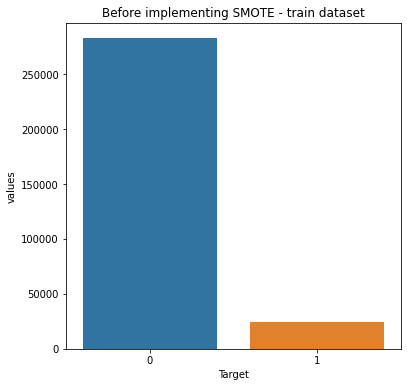

In [ ]:
temp = application_train_encoded_after_multicollinearity["TARGET"].value_counts()
df = pd.DataFrame({'Target': temp.index,
                   'values': temp.values
                  })
plt.figure(figsize = (6,6))
plt.title('Before implementing SMOTE - train dataset')
sns.set_color_codes("pastel")
sns.barplot(x = 'Target', y="values", data=df)
locs, labels = plt.xticks()
plt.show()

In [ ]:
X = application_train_encoded_after_multicollinearity.drop('TARGET', axis=1)
y = application_train_encoded_after_multicollinearity.TARGET
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=10)

In [ ]:
from imblearn.over_sampling import SMOTE
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(application_train_encoded_after_multicollinearity.drop('TARGET', axis=1), application_train_encoded_after_multicollinearity['TARGET'])
oversampled = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

In [ ]:
oversampled.head()

,TARGET,SK_ID_CURR,CNT_CHILDREN,AMT_CREDIT,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_RATING_CLIENT_W_CITY,...,NAME_CONTRACT_TYPE,CODE_GENDER,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,1,100002,0,406597.5,351000.0,0.018801,-637,-3648.0,-2120,2,...,0,1,6,7,4,3,1,8,6,5
1,0,100003,0,1293502.5,1129500.0,0.003541,-1188,-1186.0,-291,1,...,0,0,1,4,1,1,1,3,1,39
2,0,100004,0,135000.0,135000.0,0.010032,-225,-4260.0,-2531,2,...,1,1,6,7,4,3,1,8,1,11
3,0,100006,0,312682.5,297000.0,0.008019,-3039,-9833.0,-2437,2,...,0,0,6,7,4,0,1,8,6,5
4,0,100007,0,513000.0,513000.0,0.028663,-3038,-4311.0,-3458,2,...,0,1,6,7,4,3,1,3,4,37


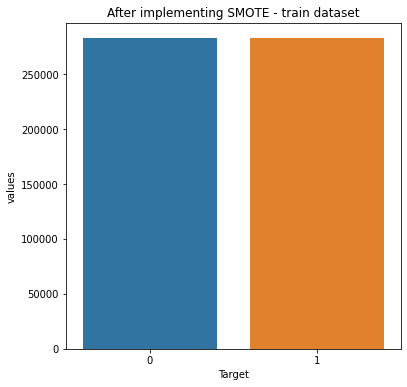

In [ ]:
temp = oversampled["TARGET"].value_counts()
df = pd.DataFrame({'Target': temp.index,
                   'values': temp.values
                  })
plt.figure(figsize = (6,6))
plt.title('After implementing SMOTE - train dataset')
sns.set_color_codes("pastel")
sns.barplot(x = 'Target', y="values", data=df)
locs, labels = plt.xticks()
plt.show()

# Modelling

## Before data mining

In [ ]:
application_train_encode= application_train_encode.drop(['hotelling', 'critical value'], axis=1)

In [ ]:
application_train_encode.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,0,1,6,7,4,3,1,8,6,5
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,0,0,1,4,1,1,1,3,1,39
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,1,1,6,7,4,3,1,8,1,11
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,0,1,6,7,4,0,1,8,6,5
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,0,1,6,7,4,3,1,3,4,37


In [ ]:
X = application_train_encode.drop('TARGET', axis=1)
y = application_train_encode.TARGET
X_train1,X_test1,y_train1,y_test1 = train_test_split(X,y,random_state=10)

### Logistic Regression

In [ ]:
model1 = LogisticRegression().fit(X_train1,y_train1)

In [ ]:
y_predict1 = model1.predict(X_test1)
roc_auc_score(y_test1,y_predict1)

0.5

In [ ]:
y_predict1

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
print(classification_report(y_test1,y_predict1))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     70668
           1       0.00      0.00      0.00      6210

    accuracy                           0.92     76878
   macro avg       0.46      0.50      0.48     76878
weighted avg       0.84      0.92      0.88     76878



### XGBClassifier

In [ ]:
model1 = XGBClassifier(random_state=12)

In [ ]:
model1.fit(X_train1,y_train1)

XGBClassifier(random_state=12)

In [ ]:
y_predict1 = model1.predict(X_test1)
roc_auc_score(y_test1,y_predict1)

0.5034294676966719

In [ ]:
sorted_idx = model1.feature_importances_.argsort()
fig = px.bar(x=model1.feature_importances_[sorted_idx][-15:],
      y=X_train1.columns[sorted_idx][-15:],
      title="Top Features Impacting Loan Repayment <br><sup> Age and the day's before the change of Identity Document are the top 2 features for loan default </sup>",
      labels={"x": "Feature Importance","y": "Features"})
fig.update_layout(title={'x':0.5,'xanchor': 'center'})
fig.show()

In [ ]:
y_predict1

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# from sklearn.metrics import classification_report
print(classification_report(y_test1,y_predict1))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     70668
           1       0.73      0.01      0.01      6210

    accuracy                           0.92     76878
   macro avg       0.83      0.50      0.49     76878
weighted avg       0.90      0.92      0.88     76878



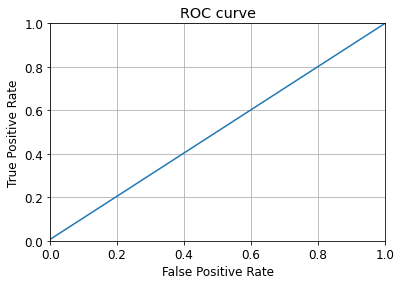

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test1,y_predict1)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### Artificial Neural Network(Classification)

In [ ]:
ann1 = tf.keras.models.Sequential()

In [ ]:
#Adding First Hidden Layer
ann1.add(tf.keras.layers.Dense(units=6,activation="relu"))
#Adding Second Hidden Layer
ann1.add(tf.keras.layers.Dense(units=6,activation="relu"))
#Adding Output Layer
ann1.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
#Compiling ANN
ann1.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])

In [ ]:
#Fitting ANN
ann1.fit(X_train1,y_train1,batch_size=32,epochs = 10)

Epoch 1/10
7208/7208 [==============================] - 13s 2ms/step - loss: 1488.7562 - accuracy: 0.8521
Epoch 2/10
7208/7208 [==============================] - 12s 2ms/step - loss: 152.7700 - accuracy: 0.8546
Epoch 3/10
7208/7208 [==============================] - 12s 2ms/step - loss: 134.8869 - accuracy: 0.8534
Epoch 4/10
7208/7208 [==============================] - 11s 2ms/step - loss: 95.1519 - accuracy: 0.8512
Epoch 5/10
7208/7208 [==============================] - 11s 2ms/step - loss: 50.1552 - accuracy: 0.8426
Epoch 6/10
7208/7208 [==============================] - 11s 2ms/step - loss: 5.7810 - accuracy: 0.8896
Epoch 7/10
7208/7208 [==============================] - 12s 2ms/step - loss: 0.2821 - accuracy: 0.9192
Epoch 8/10
7208/7208 [==============================] - 11s 2ms/step - loss: 0.2805 - accuracy: 0.9193
Epoch 9/10
7208/7208 [==============================] - 12s 2ms/step - loss: 0.2805 - accuracy: 0.9193
Epoch 10/10
7208/7208 [==============================] - 13s 2ms

In [ ]:
y_predict1 = ann1.predict(X_test1)

In [ ]:
y_predict1 = y_predict1.astype(int)
print(y_predict1)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [ ]:
print(classification_report(y_test1,y_predict1))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     70668
           1       0.00      0.00      0.00      6210

    accuracy                           0.92     76878
   macro avg       0.46      0.50      0.48     76878
weighted avg       0.84      0.92      0.88     76878



## Before SMOTE

In [ ]:
X = application_train_encoded_after_multicollinearity.drop('TARGET', axis=1)
y = application_train_encoded_after_multicollinearity.TARGET
X_train2,X_test2,y_train2,y_test2 = train_test_split(X,y,random_state=10)

### Logistic Regression

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import f1_score
# from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
# from sklearn.metrics import classification_report

In [ ]:
model2 = LogisticRegression().fit(X_train,y_train)

In [ ]:
y_predict2 = model2.predict(X_test2)
roc_auc_score(y_test2,y_predict2)

0.5

In [ ]:
print(classification_report(y_test2,y_predict2))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     70668
           1       0.00      0.00      0.00      6210

    accuracy                           0.92     76878
   macro avg       0.46      0.50      0.48     76878
weighted avg       0.84      0.92      0.88     76878



### XGBClassifier

In [ ]:
# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
model2 = XGBClassifier(random_state=12)

In [ ]:
model2.fit(X_train2,y_train2)

XGBClassifier(random_state=12)

In [ ]:
y_predict2 = model2.predict(X_test2)
roc_auc_score(y_test2,y_predict2)

0.5029251498946288

In [ ]:
sorted_idx = model2.feature_importances_.argsort()
fig = px.bar(x=model2.feature_importances_[sorted_idx][-15:],
      y=X_train2.columns[sorted_idx][-15:],
      title="Top Features Impacting Loan Repayment <br><sup> Age and the day's before the change of Identity Document are the top 2 features for loan default </sup>",
      labels={"x": "Feature Importance","y": "Features"})
fig.update_layout(title={'x':0.5,'xanchor': 'center'})
fig.show()

In [ ]:
# from sklearn.metrics import classification_report
print(classification_report(y_test2,y_predict2))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     70668
           1       0.67      0.01      0.01      6210

    accuracy                           0.92     76878
   macro avg       0.79      0.50      0.49     76878
weighted avg       0.90      0.92      0.88     76878



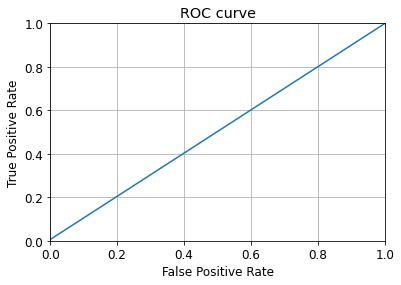

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test2,y_predict2)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### Artificial Neural Network(Classification)

In [ ]:
# import tensorflow as tf

In [ ]:
ann2 = tf.keras.models.Sequential()

In [ ]:
#Adding First Hidden Layer
ann2.add(tf.keras.layers.Dense(units=6,activation="relu"))
#Adding Second Hidden Layer
ann2.add(tf.keras.layers.Dense(units=6,activation="relu"))
#Adding Output Layer
ann2.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
#Compiling ANN
ann2.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])

In [ ]:
#Fitting ANN
ann2.fit(X_train2,y_train2,batch_size=32,epochs = 10)

Epoch 1/10
7208/7208 [==============================] - 12s 2ms/step - loss: 5.5845 - accuracy: 0.9095
Epoch 2/10
7208/7208 [==============================] - 11s 2ms/step - loss: 0.3083 - accuracy: 0.9186
Epoch 3/10
7208/7208 [==============================] - 12s 2ms/step - loss: 0.2838 - accuracy: 0.9192
Epoch 4/10
7208/7208 [==============================] - 11s 2ms/step - loss: 0.2811 - accuracy: 0.9193
Epoch 5/10
7208/7208 [==============================] - 11s 2ms/step - loss: 0.2812 - accuracy: 0.9193
Epoch 6/10
7208/7208 [==============================] - 12s 2ms/step - loss: 0.2805 - accuracy: 0.9193
Epoch 7/10
7208/7208 [==============================] - 11s 2ms/step - loss: 0.2815 - accuracy: 0.9193
Epoch 8/10
7208/7208 [==============================] - 11s 2ms/step - loss: 0.2799 - accuracy: 0.9193
Epoch 9/10
7208/7208 [==============================] - 12s 2ms/step - loss: 0.2797 - accuracy: 0.9193
Epoch 10/10
7208/7208 [==============================] - 11s 2ms/step - l

In [ ]:
y_predict2 = ann2.predict(X_test2).astype(int)
print(y_predict2)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [ ]:
print(classification_report(y_test2,y_predict2))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     70668
           1       0.00      0.00      0.00      6210

    accuracy                           0.92     76878
   macro avg       0.46      0.50      0.48     76878
weighted avg       0.84      0.92      0.88     76878



## After SMOTE

In [ ]:
oversampled.head()

,TARGET,SK_ID_CURR,CNT_CHILDREN,AMT_CREDIT,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_RATING_CLIENT_W_CITY,...,NAME_CONTRACT_TYPE,CODE_GENDER,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,1,100002,0,406597.5,351000.0,0.018801,-637,-3648.0,-2120,2,...,0,1,6,7,4,3,1,8,6,5
1,0,100003,0,1293502.5,1129500.0,0.003541,-1188,-1186.0,-291,1,...,0,0,1,4,1,1,1,3,1,39
2,0,100004,0,135000.0,135000.0,0.010032,-225,-4260.0,-2531,2,...,1,1,6,7,4,3,1,8,1,11
3,0,100006,0,312682.5,297000.0,0.008019,-3039,-9833.0,-2437,2,...,0,0,6,7,4,0,1,8,6,5
4,0,100007,0,513000.0,513000.0,0.028663,-3038,-4311.0,-3458,2,...,0,1,6,7,4,3,1,3,4,37


In [ ]:
oversampled.shape

(565372, 34)

In [ ]:
X = oversampled.drop('TARGET', axis=1)
y = oversampled.TARGET
X_train3,X_test3,y_train3,y_test3 = train_test_split(X,y,random_state=10)

### Logistic Regression

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import f1_score
# from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
# from sklearn.metrics import classification_report

In [ ]:
model3 = LogisticRegression().fit(X_train,y_train)

In [ ]:
y_predict3 = model3.predict(X_test3)
roc_auc_score(y_test3,y_predict3)

0.5

In [ ]:
print(classification_report(y_test3,y_predict3))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67     70857
           1       0.00      0.00      0.00     70486

    accuracy                           0.50    141343
   macro avg       0.25      0.50      0.33    141343
weighted avg       0.25      0.50      0.33    141343



### XGBClassifier

In [ ]:
# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
model3 = XGBClassifier(random_state=12)

In [ ]:
model3.fit(X_train3,y_train3)

XGBClassifier(random_state=12)

In [ ]:
y_predict3 = model3.predict(X_test3)
roc_auc_score(y_test3,y_predict3)

0.87076697159493

In [ ]:
sorted_idx = model3.feature_importances_.argsort()
fig = px.bar(x=model3.feature_importances_[sorted_idx][-15:],
      y=X_train3.columns[sorted_idx][-15:],
      title="Top Features Impacting Loan Repayment <br><sup> Age and the day's before the change of Identity Document are the top 2 features for loan default </sup>",
      labels={"x": "Feature Importance","y": "Features"})
fig.update_layout(title={'x':0.5,'xanchor': 'center'})
fig.show()

In [ ]:
# from sklearn.metrics import classification_report
print(classification_report(y_test3,y_predict3))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87     70857
           1       0.88      0.85      0.87     70486

    accuracy                           0.87    141343
   macro avg       0.87      0.87      0.87    141343
weighted avg       0.87      0.87      0.87    141343



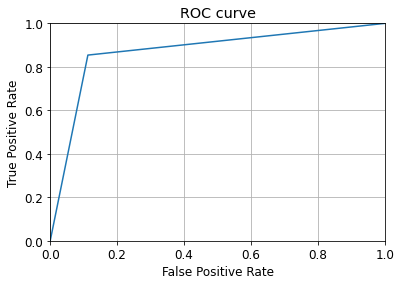

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test3,y_predict3)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### Artificial Neural Network(Classification)

In [ ]:
# import tensorflow as tf

In [ ]:
ann3 = tf.keras.models.Sequential()

In [ ]:
#Adding First Hidden Layer
ann3.add(tf.keras.layers.Dense(units=6,activation="relu"))
#Adding Second Hidden Layer
ann3.add(tf.keras.layers.Dense(units=6,activation="relu"))
#Adding Output Layer
ann3.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
#Compiling ANN
ann3.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])

In [ ]:
#Fitting ANN
ann3.fit(X_train3,y_train3,batch_size=32,epochs = 10)

Epoch 1/10
13251/13251 [==============================] - 22s 2ms/step - loss: 147.7466 - accuracy: 0.5015
Epoch 2/10
13251/13251 [==============================] - 22s 2ms/step - loss: 0.6943 - accuracy: 0.5001
Epoch 3/10
13251/13251 [==============================] - 22s 2ms/step - loss: 0.6932 - accuracy: 0.4999
Epoch 4/10
13251/13251 [==============================] - 22s 2ms/step - loss: 0.6932 - accuracy: 0.4995
Epoch 5/10
13251/13251 [==============================] - 22s 2ms/step - loss: 0.6932 - accuracy: 0.5003
Epoch 6/10
13251/13251 [==============================] - 22s 2ms/step - loss: 0.6931 - accuracy: 0.5004
Epoch 7/10
13251/13251 [==============================] - 22s 2ms/step - loss: 0.6932 - accuracy: 0.4997
Epoch 8/10
13251/13251 [==============================] - 22s 2ms/step - loss: 0.6932 - accuracy: 0.5004
Epoch 9/10
13251/13251 [==============================] - 21s 2ms/step - loss: 0.6932 - accuracy: 0.5010
Epoch 10/10
13251/13251 [============================

In [ ]:
y_predict3 = ann3.predict(X_test3).astype(int)
print(y_predict3)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [ ]:
print(classification_report(y_test3,y_predict3))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67     70857
           1       0.00      0.00      0.00     70486

    accuracy                           0.50    141343
   macro avg       0.25      0.50      0.33    141343
weighted avg       0.25      0.50      0.33    141343

